In [1]:
import pickle
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Naključno vzbujanje - ocena frekvenčnih prenosnih funkcij

Spomnimo se:

:::{note}

**Frekvenčna prenosna funkcija** $\alpha(\omega)$ predstavlja razmerje med (kompleksnimi) amplitudami harmonskega odziva in vzbujanja opazovanega sistema:

$$
	\alpha(\omega) = \frac{X(\omega)}{F(\omega)}
$$

:::

Določamo razmerje med odzivom sistema $x(t)$ in znanim signalom vzbujanja $f(t)$, ki smo jih pomerili na [vaji 9](./notebooks/09%20-%20Naklju%C4%8Dno%20vzbujanje%2C%20zajem%20signalov.ipynb). Signali so bili pridobljeni z uporabo *naključnega, širokospektralnega, stacionarnega* vzbujanja.

Namen te vaje je spoznati metode procesiranja signalov za določitev cenilk frekvenčnih prenosnih funkcij linearnega sistema na podlagi tovrstnih meritev.

## Domača naloga

:::{admonition} Domača naloga
:class: warning

V okolju Jupyter Notebook pripravite kratko poročilo *(od 3 do 10 celic s kodo)* z rezultati in kratkim komentarjem izvedenih meritev ter izračunanih cenilk frekvenčne prenosne funkcije glede na podatke naloge. Dodeljeni podatki naloge naj bodo v poročilu navedeni. Poročilo naj vsebuje:

* prikaz PSD vaše meritve (povprečje vseh segmentov, v točki, določeni v podatkih [naloge 9](./notebooks/09%20-%20Naklju%C4%8Dno%20vzbujanje%2C%20zajem%20signalov.ipynb)),
* prikaz frekvenčne prenosne funkcije v vaši izmerjeni točki ($i$), ki jo ocenite z $\alpha_i(\omega) = X_i(\omega) / F_i(\omega)$.
* prikaz frekvenčne prenosne funkcije v vaši izmerjeni točki ($i$), izračunane s cenilko $H_1(\omega)$ ali $H_2(\omega)$ (glede na podatke naloge). Pri tem povprečite spektre ($G_{xy}$) izmerjenih signalov, razdeljenih na segmente dolžine 2 s.


**Dodatek**: 
* Izračunajte in prikažite obe cenilki frekvenčne prenosne funkcije ($H_1$, $H_2$). 
    * Križne- in avtospektre signalov pri tem izračunajte s povprečenjem prekritih segmentov in uporabo oknjenja,
    * Dolžina posameznega segmenta izračuna PSD in CSD je določena v podatkih naloge, uporabite 50% prekrivanjem segmentov,
    * Na posameznem segmentu za zmanjševanje pojava frekvenčnega odtekanja uporabite okno, določeno v podatkih naloge.
* Izračunajte in prikažite tudi koherenco meritve FRF, $\gamma^2_{fx}(\omega)$.

Poročilo oddajte v `.pdf` obliki (glejte [navodila za oddajo domačih nalog](intro-domace-naloge)).

:::

---

## Branje izmerjenih signalov

:::{admonition} Parametri izvedene meritve
:class: seealso

Frekvenčne prenosne funkcije jeklenega nosilca bomo izračunali na podlagi meritev, izvedenih pri [vaji 9](./notebooks/09%20-%20Naklju%C4%8Dno%20vzbujanje%2C%20zajem%20signalov.ipynb).

Pri procesiranju zajetih signalov so pomembni tudi parametri izvedene meritve. Če ste meritvah sledili navodilom, so osnovni parametri vaših signalov naslednji:

Osnovni parametri zajema (**če ste pri meritvi uporabili drugačne nastavitve, vrednosti po potrebi prilagodite!**):
* Dva kanala: *sila* in *pospešek* (IEPE).
* Frekvenca vzorčenja: 25600 Hz,
* Trajanje vsakega zajetega segmenta: 2 s,
* Število zajetih segmentov: 5.


Osnovne značilnosti meritve:
* 11 označenih merilnih mest (na pozicijah $[25, 475]$ mm, razmik $45$ mm).
* Vzbujanje na lokaciji $0$, meritve odziva na lokacijah $i \in [1, 2, \dots 10]$.
* Trajanje vsakega generiranega segmenta: 2 s,
* Profil naključnega vzbujevalnega signala konstantne amplitude na območju $[10, 3000] Hz$,
* Povprečne amplitude vzbujevalne sile: 1 N RMS.

:::


Branje shranjene datoteke - meritev v eni izmed označenih točk

In [2]:
pot = './data/10/meritev.pkl'

meritev = pickle.load(open(pot, 'rb'))
print(meritev.keys())

dict_keys(['data', 'fs', 'channels'])


Frekvenca vzorčenja in shranjeni kanali

In [3]:
fs = meritev['fs']
print(fs, meritev['channels'])

25600.0 ['Force', 'Acceleration']


Oblika shranjenih signalov (`segmenti, kanali, čas`)

In [4]:
print(meritev['data'].shape)

(5, 2, 51200)


Izbira segmenta za analizo

In [5]:
force, acc = meritev['data'].transpose(1, 0, 2) # transponiranje signalov tako, da imamo na prvi osi oba pomerjena kanala, silo in pospešek
force.shape

(5, 51200)

In [6]:
time = np.arange(force.shape[1]) / fs

In [7]:
F = np.fft.rfft(force, axis=-1) / force.shape[-1] * 2 # izračun FFT: po časovni osi
A = np.fft.rfft(acc, axis=-1) / acc.shape[-1] * 2
F.shape

(5, 25601)

In [8]:
freq = np.fft.rfftfreq(len(time), 1/fs)
freq.shape

(25601,)

Izris amplitudnih spektrov

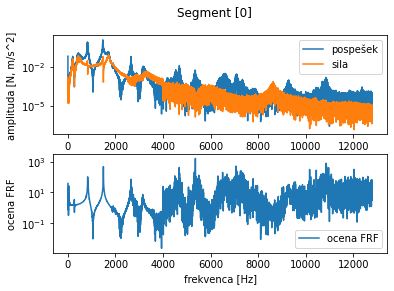

In [9]:
segment = 0

fig, ax = plt.subplots(2, 1)
plt.suptitle(f'Segment [{segment}]')
ax[0].semilogy(freq, np.abs(A[segment]), label='pospešek')
ax[0].semilogy(freq, np.abs(F[segment]), label='sila')
ax[0].set_xlabel('frekvenca [Hz]')
ax[0].set_ylabel('amplituda [N, m/s^2]')
ax[0].legend()

ax[1].semilogy(freq, np.abs(A/F)[segment], label='ocena FRF')
ax[1].set_xlabel('frekvenca [Hz]')
ax[1].set_ylabel('ocena FRF')
ax[1].legend();

## Cenilke frekvenčne prenosne funkcije

Pri realnih meritvah se ne moremo izogniti naključnega šuma (merilne napake) v zajetih signalih. 

Ob upoštevanju odziva LTI sistemov na naključno vzbujanje z merilno napako, lahko zapišemo različne cenilke frekvenčnih prenosnih funkcij:

:::{note}

Cenilka $H_1(\omega)$ predpostavlja nezanemarljivo količino naključnega šuma pri meritvi signala *odziva* $x(t)$. Izračunamo jo:

$$
\begin{equation}
H_1(\omega) = \frac{S_{fx}(\omega)}{S_{ff}(\omega)}.
\end{equation}
$$

:::

:::{note}

Cenilka $H_2(\omega)$ predpostavlja nezanemarljivo količino naključnega šuma pri meritvi signala *vzbujanja* $f(t)$. Izračunamo jo:

$$
\begin{equation}
H_2(\omega) = \frac{S_{xx}(\omega)}{S_{xf}(\omega)}.
\end{equation}
$$

:::

:::{note}

Kvaliteto meritve lahko ocenimo s **koherenco**. Ta je definirana kot:

$$
\gamma_{fx}^2(f)=\frac{|G_{fx}(f)|^2}{G_{ff}(f)\,G_{xx}(f)}
=\frac{|S_{fx}(f)|^2}{S_{ff}(f)\,S_{xx}(f)}
= \frac{H_1(\omega)}{H_2(\omega)}
$$


Koherenca ima vrednosti na območju $\gamma_{fx}^2(f) \in [0, 1]$. Podaja merilo linearne odvisnosti signalov na vhodu (vzbujanje, $f$) in izhodu (odziv, $x$) sistema. 

**Pozor:** Izračun koherence je smiseln samo, če so spektralne gostote moči $S_{fx}$, $S_{xx}$, $S_{ff}$ določene s povprečenjem več zajetih segmentov naključnega procesa!

:::

### Izračun cenilke $H1$

Izračun spektrov (ker bomo pri izračunu FR spektre delili med sabo, amplitudno normiranje ni potrebno)

In [10]:
G_fa = F.conj() * A 
G_ff = F.conj() * F

In [11]:
H1 = G_fa / G_ff

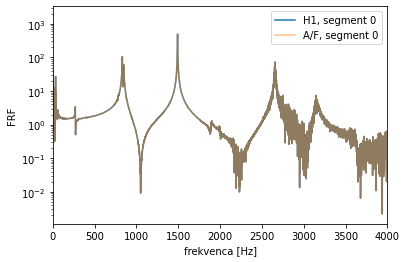

In [12]:
plt.figure()
plt.semilogy(freq, np.abs(H1[segment]), label=f'H1, segment {segment}')
plt.semilogy(freq, np.abs(A[segment] / F[segment]), alpha=0.5, label=f'A/F, segment {segment}')
plt.xlim(0, 4000)
plt.xlabel('frekvenca [Hz]')
plt.ylabel('FRF')
plt.legend();

S povprečenjem

In [13]:
H1_povprečenje = np.mean(G_fa, axis=0) / np.mean(G_ff, axis=0)

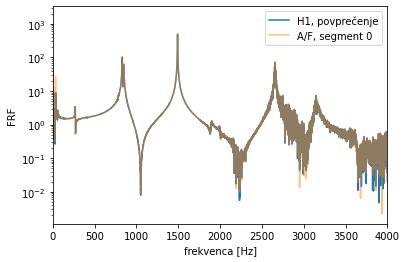

In [14]:
plt.figure()
plt.semilogy(freq, np.abs(H1_povprečenje), label=f'H1, povprečenje')
plt.semilogy(freq, np.abs(A[segment] / F[segment]), alpha=0.5, label=f'A/F, segment {segment}')
plt.xlim(0, 4000)
plt.xlabel('frekvenca [Hz]')
plt.ylabel('FRF')
plt.legend();

### Izračun povprečenih spektralnih gostot moči s prekrivanjem segmentov in uporabo oken

[Welcheva metoda](https://en.wikipedia.org/wiki/Welch%27s_method) določi (križne in avto-) spektralne gostote moči signalov z uporabo povprečenja in oknjenja podanega signala, segmentiranega s prekrivanjem posameznih odsekov.

V Scipy je implementirana v [`scipy.signal.csd`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.csd.html) (križno-spektralna gostota moči) in [`scipy.signal.welch`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html) (avtospektralna gostota moči). Glavni parametri `scipy.signal.csd` so:
* `x` : prvi signal.
* `y` : drugi signal.
* `fs` : frekvenca vzorčenja signalov `x` in `y`,
* `window` : okno, ki naj se uporabi na posameznem segmentu. Privzeto `"hann"`.
* `nperseg` : dolžina posameznega odseka signala pri segmentiranju,
* `noverlap` : število vzorcev, ki se med segmenti prekrivajo. Privzeto polovica `nperseg`.

### Cenilka $H2$ z metodo Welch

Ker imamo v vseh segmentih naključno vzbujanje, lahko zajete segmente združimo:

In [15]:
a = np.hstack(acc)
f = np.hstack(force)
a.shape

(256000,)

In [16]:
freq_welch, G_aa = signal.csd(a, a, nperseg=len(time)//4, fs=fs)
freq_welch, G_af = signal.csd(a, f, nperseg=len(time)//4, fs=fs)

(Za ustrezno normiranje križnih in avtospektrov glejte ostale argumente funkcije `csd`. Pri izračunu FRF normiranje spektrov na rezultat ne vpliva.)

In [17]:
H2_welch = G_aa / G_af
H2_welch.shape, freq_welch.shape

((6401,), (6401,))

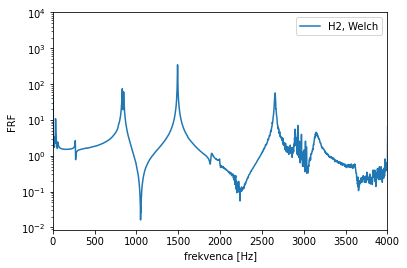

In [18]:
plt.figure()
plt.semilogy(freq_welch, np.abs(H2_welch), label=f'H2, Welch')
plt.xlim(0, 4000)
plt.xlabel('frekvenca [Hz]')
plt.ylabel('FRF')
plt.legend();